In [154]:
from pathlib import Path
import json
import math
import re

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import pandas as pd

# High-contrast palette for clear differentiation
MUTED_COLORS = [
    "#1f77b4",  # bright blue
    "#ff7f0e",  # vivid orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf",  # cyan
]

def extract_model_suffix(model_name: str) -> str:
    """Extract the suffix from model name (e.g., 'clean', 'noisy20', 'noisy40', 'noisy48')."""
    # Pattern to match suffixes like clean, noisy20, noisy40, noisy48
    patterns = [
        r'noisy(\d+)',  # matches noisy20, noisy40, noisy48
        r'clean',       # matches clean
    ]
    
    for pattern in patterns:
        match = re.search(pattern, model_name, re.IGNORECASE)
        if match:
            if 'noisy' in pattern:
                return f"noisy{match.group(1)}"
            else:
                return "clean"
    
    return "unknown"

def plot_many(
    trainer_state_paths,
    checkpoint_num=None,
    smoothing=None,
    fields_to_plot=None,
    legend_labels=None,
    title=None,
    x_title=None,
    y_title=None,
    subplot_titles=None,
):
    """
    Plot training metrics from trainer state files.
    
    Args:
        trainer_state_paths: Path(s) to trainer state files or directory containing models
        checkpoint_num: Specific checkpoint number to use (None = use latest)
        smoothing: If set (>1), apply spline smoothing with ~3x samples (or at least `smoothing` samples)
        fields_to_plot: List of field names to plot (None = plot all numeric fields)
        legend_labels: Optional labels for each trainer_state path (same length as paths)
        title: Optional overall figure title
        x_title: Optional x-axis label for all subplots
        y_title: Optional y-axis label for all subplots
        subplot_titles: Optional list of titles per subplot (same length as fields_to_plot/value_cols)
    """
    if not isinstance(trainer_state_paths, (list, tuple)):
        base_path = Path(trainer_state_paths)
        if base_path.is_dir():
            trainer_state_paths = []
            for model_dir in base_path.iterdir():
                if not model_dir.is_dir():
                    continue
                checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
                if not checkpoints:
                    continue
                checkpoint_numbers = []
                for cp in checkpoints:
                    try:
                        num = int(cp.name.split("-")[1])
                        checkpoint_numbers.append((num, cp))
                    except (ValueError, IndexError):
                        continue
                if checkpoint_numbers:
                    if checkpoint_num is not None:
                        target_checkpoint = None
                        for num, cp in checkpoint_numbers:
                            if num == checkpoint_num:
                                target_checkpoint = cp
                                break
                        if target_checkpoint is None:
                            continue
                    else:
                        target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
                    trainer_state_file = target_checkpoint / "trainer_state.json"
                    if trainer_state_file.exists():
                        trainer_state_paths.append(trainer_state_file)
        else:
            trainer_state_paths = [base_path]
    
    if not trainer_state_paths:
        raise ValueError("No trainer state files found")
    
    all_log_dfs = []
    path_labels = []
    
    for trainer_state_path in trainer_state_paths:
        with trainer_state_path.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            raise ValueError(f"log_history is empty in {trainer_state_path}")
        
        log_df = pd.DataFrame(log_history)
        all_log_dfs.append(log_df)
        path_labels.append(trainer_state_path.parent.parent.name)
    
    if not all_log_dfs:
        raise ValueError("No valid trainer states found")
    
    display(all_log_dfs[0].head())
    
    if legend_labels is not None and len(legend_labels) != len(path_labels):
        print(f"Warning: legend_labels has length {len(legend_labels)} but {len(path_labels)} paths were provided; ignoring custom labels.")
        legend_labels = None
    legend_labels = legend_labels or path_labels
    
    value_cols = [
        col for col in all_log_dfs[0].columns
        if pd.api.types.is_numeric_dtype(all_log_dfs[0][col]) and col != "step"
    ]
    
    # Filter to only requested fields if specified
    if fields_to_plot is not None:
        available_fields = [col for col in fields_to_plot if col in value_cols]
        missing_fields = [col for col in fields_to_plot if col not in value_cols]
        if missing_fields:
            print(f"Warning: Fields not found: {missing_fields}")
        if not available_fields:
            raise ValueError(f"None of the requested fields {fields_to_plot} were found in the data")
        value_cols = available_fields
    
    if subplot_titles is not None and len(subplot_titles) != len(value_cols):
        print(f"Warning: subplot_titles has length {len(subplot_titles)} but {len(value_cols)} subplots will be drawn; ignoring custom subplot titles.")
        subplot_titles = None
    
    num_plots = len(value_cols)
    n_cols = 2
    n_rows = math.ceil(num_plots / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3.25 * n_rows), squeeze=False)
    
    for idx, (ax, col) in enumerate(zip(axes.flat, value_cols)):
        for line_idx, (log_df, label) in enumerate(zip(all_log_dfs, legend_labels)):
            color = MUTED_COLORS[line_idx % len(MUTED_COLORS)]
            x_values = log_df["step"] if "step" in log_df.columns else range(len(log_df))
            if col in log_df.columns:
                y_values = log_df[col]
                x_arr = np.asarray(x_values)
                y_arr = y_values.to_numpy()
                if smoothing is not None and smoothing > 1:
                    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
                    x_clean = x_arr[mask]
                    y_clean = y_arr[mask]
                else:
                    x_clean = x_arr
                    y_clean = y_arr
                if smoothing is not None and smoothing > 1 and len(x_clean) >= 4:
                    try:
                        sort_idx = np.argsort(x_clean)
                        x_sorted = x_clean[sort_idx]
                        y_sorted = y_clean[sort_idx]
                        unique_x, uniq_idx = np.unique(x_sorted, return_index=True)
                        x_sorted = unique_x
                        y_sorted = y_sorted[uniq_idx]
                        if len(x_sorted) >= 4:
                            num_points = max(len(x_sorted) * 3, int(smoothing))
                            x_dense = np.linspace(x_sorted.min(), x_sorted.max(), num=num_points)
                            k = min(3, len(x_sorted) - 1)
                            spline = make_interp_spline(x_sorted, y_sorted, k=k)
                            y_dense = spline(x_dense)
                            ax.plot(x_dense, y_dense, linewidth=1.5, label=label, color=color)
                        else:
                            ax.plot(x_sorted, y_sorted, linewidth=1.5, label=label, color=color)
                    except Exception as exc:
                        print(f"Warning: spline smoothing failed for {label}/{col}: {exc}; plotting raw values.")
                        ax.plot(x_clean, y_clean, linewidth=1.5, label=label, color=color)
                else:
                    ax.plot(x_clean, y_clean, linewidth=1.5, label=label, color=color)
        
        ax.set_title(subplot_titles[idx] if subplot_titles else col)
        ax.set_xlabel(x_title or ("step" if "step" in all_log_dfs[0].columns else "index"))
        ax.set_ylabel(y_title or col)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    for ax in axes.flat[num_plots:]:
        ax.axis("off")
    
    if title:
        fig.suptitle(title)
        plt.tight_layout(rect=(0, 0, 1, 0.96))
    else:
        plt.tight_layout()
    plt.show()

def group_models_by_suffix(base_path: Path, checkpoint_num=None):
    """Group model directories by their suffix (clean, noisy20, noisy40, noisy48)."""
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    groups = {}
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        suffix = extract_model_suffix(model_dir.name)
        if suffix not in groups:
            groups[suffix] = []
        groups[suffix].append(trainer_state_file)
    
    return groups


def collect_trainer_state_paths(base_path, models=None, paths=None, checkpoint_num=None):
    """
    Build a list of trainer_state.json files from model directory names and/or explicit paths.

    Args:
        base_path: Root folder containing model directories.
        models: Iterable of model directory names relative to base_path.
        paths: Iterable of explicit paths to model dirs, checkpoint dirs, or trainer_state.json files.
        checkpoint_num: Specific checkpoint to use; default picks the latest.
    """
    base_path = Path(base_path)
    models = models or []
    paths = paths or []
    trainer_state_paths = []
    
    def _checkpoint_dir(model_dir: Path):
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            return None
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        if not checkpoint_numbers:
            return None
        if checkpoint_num is not None:
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    return cp
            return None
        return max(checkpoint_numbers, key=lambda x: x[0])[1]
    
    def _add_trainer_state(model_dir: Path):
        target_cp = _checkpoint_dir(model_dir)
        if target_cp is None:
            print(f"Skipping {model_dir}: no matching checkpoints")
            return
        ts_file = target_cp / "trainer_state.json"
        if ts_file.exists():
            trainer_state_paths.append(ts_file)
        else:
            print(f"Skipping {model_dir}: missing trainer_state.json in {target_cp}")
    
    for model_name in models:
        model_dir = base_path / model_name
        if model_dir.is_dir():
            _add_trainer_state(model_dir)
        else:
            print(f"Skipping missing model dir: {model_dir}")
    
    for p in paths:
        candidate = Path(p)
        if candidate.is_file():
            if candidate.name == "trainer_state.json":
                trainer_state_paths.append(candidate)
            else:
                print(f"Skipping unsupported file: {candidate}")
            continue
        if candidate.is_dir():
            if candidate.name.startswith("checkpoint-"):
                ts_file = candidate / "trainer_state.json"
                if ts_file.exists():
                    trainer_state_paths.append(ts_file)
                else:
                    print(f"Skipping {candidate}: missing trainer_state.json")
            else:
                _add_trainer_state(candidate)
        else:
            print(f"Skipping missing path: {candidate}")
    
    if not trainer_state_paths:
        raise ValueError("No trainer_state.json files found for provided selection")
    
    return trainer_state_paths


def plot_selected(
    base_path,
    models=None,
    paths=None,
    checkpoint_num=None,
    smoothing=None,
    fields_to_plot=None,
    legend_labels=None,
    title=None,
    x_title=None,
    y_title=None,
    subplot_titles=None,
):
    """Convenience wrapper to plot a specific set of models or trainer_state files."""
    trainer_state_paths = collect_trainer_state_paths(
        base_path=base_path,
        models=models,
        paths=paths,
        checkpoint_num=checkpoint_num,
    )
    return plot_many(
        trainer_state_paths,
        checkpoint_num=checkpoint_num,
        smoothing=smoothing,
        fields_to_plot=fields_to_plot,
        legend_labels=legend_labels,
        title=title,
        x_title=x_title,
        y_title=y_title,
        subplot_titles=subplot_titles,
    )



Found 4 groups: ['clean', 'noisy20', 'noisy40', 'noisy48']
  clean: 6 models
  noisy40: 10 models
  noisy48: 3 models
  noisy20: 6 models

Plotting group: clean


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.587500,0.01032,14.782914,0.000010,0.5556,0.327066,2.382681,-0.829744,-4.922388,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.590625,0.02064,5.832210,0.000010,0.5507,0.332259,3.566801,0.564292,-3.873759,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.675000,0.03096,7.563941,0.000010,0.4870,0.761989,5.351327,0.066622,-3.256768,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.657813,0.04128,8.700788,0.000010,0.4883,0.965408,10.191773,3.603652,-0.920451,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.643750,0.05160,6.100352,0.000009,0.4913,0.715380,6.673474,2.283805,-1.582816,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


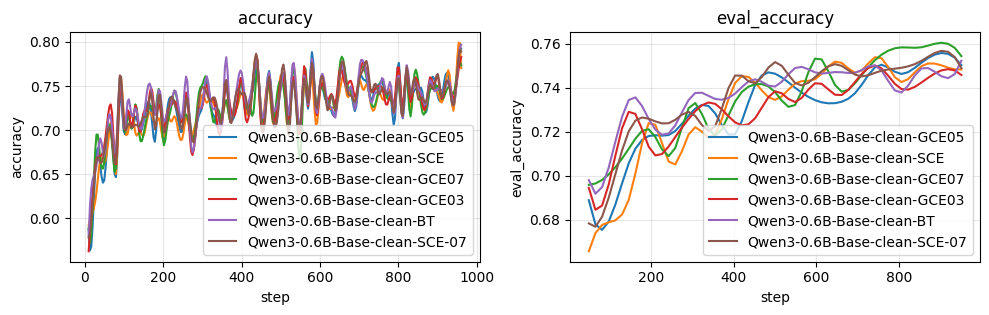


Plotting group: noisy20


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.570312,0.01032,7.442329,0.000010,0.5293,0.158503,5.904214,3.173551,-1.080381,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,7.998268,0.000010,0.5434,0.295973,7.051212,2.803451,-2.719099,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.625000,0.03096,6.547256,0.000010,0.4776,0.645610,6.329265,1.400977,-3.315802,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.618750,0.04128,5.947553,0.000010,0.4934,0.520184,6.897339,2.288440,-2.039699,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.584375,0.05160,4.356923,0.000009,0.5147,0.430439,6.357493,1.711673,-2.527280,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


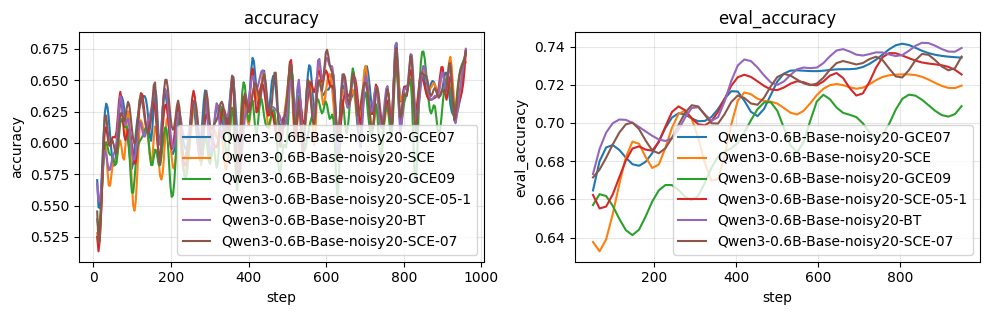


Plotting group: noisy40


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.495312,0.01032,17.233334,0.000010,1.9360,-0.018707,2.391272,-0.546773,-3.178073,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.504687,0.02064,9.825512,0.000010,1.8948,-0.000382,2.001366,0.518537,-1.640883,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.534375,0.03096,9.253069,0.000010,1.8654,0.020132,-0.313145,-1.847801,-3.729898,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.482812,0.04128,6.179500,0.000010,1.9030,-0.022981,-1.692664,-3.257754,-4.898384,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.542188,0.05160,7.286939,0.000009,1.8479,0.035322,-1.630976,-2.989393,-4.557408,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


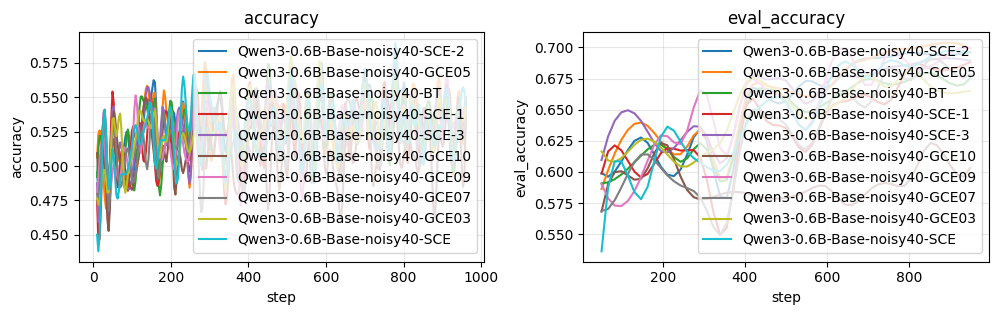


Plotting group: noisy48


,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.525000,0.01032,7.500800,0.000010,0.5556,0.049746,4.555255,-0.340357,-3.113806,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.485938,0.02064,2.619746,0.000010,0.5805,-0.109715,10.558673,0.922915,-1.196203,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.498437,0.03096,2.022751,0.000010,0.5541,-0.009290,-0.003442,-1.310405,-2.298844,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.464062,0.04128,1.381833,0.000010,0.5575,-0.021838,1.234350,0.255949,-0.434748,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.478125,0.05160,1.555659,0.000009,0.5535,-0.010731,1.644073,0.982398,0.342574,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


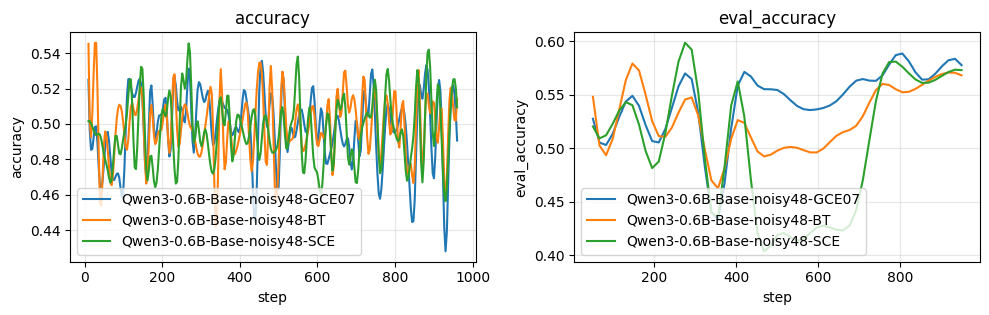

In [155]:
# Plot all groups separately, showing only accuracy and eval_accuracy
base_path = Path("models_final/")
groups = group_models_by_suffix(base_path)

print(f"Found {len(groups)} groups: {sorted(groups.keys())}")
for suffix, paths in groups.items():
    print(f"  {suffix}: {len(paths)} models")

# Plot each group separately
for suffix, trainer_state_paths in sorted(groups.items()):
    print(f"\nPlotting group: {suffix}")
    plot_many(trainer_state_paths, smoothing=10, fields_to_plot=["accuracy", "eval_accuracy"])

In [156]:
# values
from pathlib import Path
import json
import pandas as pd

def output_metrics(base_path, checkpoint_num=None, metrics_to_show=None):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise ValueError(f"{base_path} is not a directory")
    
    results = []
    
    for model_dir in base_path.iterdir():
        if not model_dir.is_dir():
            continue
        
        checkpoints = [d for d in model_dir.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoints:
            continue
        
        checkpoint_numbers = []
        for cp in checkpoints:
            try:
                num = int(cp.name.split("-")[1])
                checkpoint_numbers.append((num, cp))
            except (ValueError, IndexError):
                continue
        
        if not checkpoint_numbers:
            continue
        
        if checkpoint_num is not None:
            target_checkpoint = None
            for num, cp in checkpoint_numbers:
                if num == checkpoint_num:
                    target_checkpoint = cp
                    break
            if target_checkpoint is None:
                continue
        else:
            target_checkpoint = max(checkpoint_numbers, key=lambda x: x[0])[1]
        
        trainer_state_file = target_checkpoint / "trainer_state.json"
        if not trainer_state_file.exists():
            continue
        
        with trainer_state_file.open() as fp:
            trainer_state = json.load(fp)
        
        log_history = trainer_state.get("log_history", [])
        if not log_history:
            continue
        
        log_df = pd.DataFrame(log_history)
        
        model_name = model_dir.name
        checkpoint_used = target_checkpoint.name
        
        # If filtering to specific metrics, find the last entry that has those metrics
        if metrics_to_show is not None:
            # Find entries that have at least one of the requested metrics
            available_cols = set(log_df.columns)
            requested_cols = set(metrics_to_show)
            missing_cols = requested_cols - available_cols
            if missing_cols:
                print(f"Warning: {model_name} - missing columns: {missing_cols}")
            
            # Find the last entry that has any of the requested metrics (non-NaN)
            last_entry = None
            if "step" in log_df.columns:
                # Sort by step descending and find first entry with requested metrics
                sorted_df = log_df.sort_values("step", ascending=False)
                for idx, row in sorted_df.iterrows():
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            else:
                # Check from the end backwards
                for idx in range(len(log_df) - 1, -1, -1):
                    row = log_df.iloc[idx]
                    has_metrics = False
                    for col in metrics_to_show:
                        if col in log_df.columns and pd.notna(row[col]):
                            has_metrics = True
                            break
                    if has_metrics:
                        last_entry = row
                        break
            
            if last_entry is None:
                # Fallback to last entry even if NaN
                if "step" in log_df.columns:
                    last_entry = log_df.loc[log_df["step"].idxmax()]
                else:
                    last_entry = log_df.iloc[-1]
        else:
            # Show all metrics - use last entry
            if "step" in log_df.columns:
                last_entry = log_df.loc[log_df["step"].idxmax()]
            else:
                last_entry = log_df.iloc[-1]
        
        metrics = {}
        for col in log_df.columns:
            if pd.api.types.is_numeric_dtype(log_df[col]) and col != "step":
                if metrics_to_show is None or col in metrics_to_show:
                    metrics[col] = last_entry[col]
        
        results.append({
            "model": model_name,
            **metrics
        })
    
    if not results:
        print("No results found")
        return
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values("model")
    
    return results_df

display(output_metrics(Path("models_final/"), metrics_to_show=["eval_accuracy", "eval_margin"]))
display(output_metrics(Path("models_epoch3/"), metrics_to_show=["eval_accuracy", "eval_margin"]))


,model,eval_accuracy,eval_margin
20,Qwen3-0.6B-Base-clean-BT,0.752344,1.085453
18,Qwen3-0.6B-Base-clean-GCE03,0.745898,1.517395
0,Qwen3-0.6B-Base-clean-GCE05,0.750391,2.059500
16,Qwen3-0.6B-Base-clean-GCE07,0.754492,3.346831
13,Qwen3-0.6B-Base-clean-SCE,0.748438,3.571979
23,Qwen3-0.6B-Base-clean-SCE-07,0.749023,1.774218
21,Qwen3-0.6B-Base-noisy20-BT,0.739258,0.418071
4,Qwen3-0.6B-Base-noisy20-GCE07,0.734180,1.705286
11,Qwen3-0.6B-Base-noisy20-GCE09,0.708789,4.827339
5,Qwen3-0.6B-Base-noisy20-SCE,0.719531,2.104979


,model,eval_accuracy,eval_margin
5,Qwen3-0.6B-Base-clean-BT,0.733789,12.129924
4,Qwen3-0.6B-Base-clean-GCE07,0.719531,9.906538
6,Qwen3-0.6B-Base-noisy20-BT,0.641992,5.416716
0,Qwen3-0.6B-Base-noisy20-GCE07,0.687695,6.485916
1,Qwen3-0.6B-Base-noisy20-SCE,0.669727,2.998012
2,Qwen3-0.6B-Base-noisy40-BT,0.575977,1.022830
3,Qwen3-0.6B-Base-noisy40-GCE09,0.624219,3.351973


Results

In [164]:
# Manual grouping of final checkpoints by noise level
final_base_path = Path("/proj/inf-scaling/iris/dl-rm-loss/reward_modeling/models_final")
final_groups = {
    "clean": [
        final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE05/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE-07/checkpoint-969",
    ],
    "noisy20": [
        final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-05-1/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-07/checkpoint-969",
    ],
    "noisy40": [
        final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE03/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE05/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE10/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-1/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-2/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-3/checkpoint-969",
    ],
    "noisy48": [
        final_base_path / "Qwen3-0.6B-Base-noisy48-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy48-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy48-SCE/checkpoint-969",
    ],
}

In [172]:
# Group by loss type (bt/gce/sce) and noise level (clean, noisy20, noisy40)
final_groups_by_loss_and_noise = {
    "bt": {
        "clean": [final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969"],
        "noisy20": [final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969"],
        "noisy40": [final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969"],
    },
    "gce": {
        "clean": [
            final_base_path / "Qwen3-0.6B-Base-clean-GCE03/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE05/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
        ],
        "noisy20": [
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-GCE09/checkpoint-969",
        ],
        "noisy40": [
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE03/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE05/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE07/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-GCE10/checkpoint-969",
        ],
    },
    "sce": {
        "clean": [
            final_base_path / "Qwen3-0.6B-Base-clean-SCE/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-clean-SCE-07/checkpoint-969",
        ],
        "noisy20": [
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-05-1/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy20-SCE-07/checkpoint-969",
        ],
        "noisy40": [
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-1/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-2/checkpoint-969",
            final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-3/checkpoint-969",
        ],
    },
}

In [166]:
best_groups = {
    "clean": [
        final_base_path / "Qwen3-0.6B-Base-clean-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-clean-SCE/checkpoint-969",
    ],
    "noisy20": [
        final_base_path / "Qwen3-0.6B-Base-noisy20-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy20-SCE/checkpoint-969",
    ],
    "noisy40": [
        final_base_path / "Qwen3-0.6B-Base-noisy40-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-GCE09/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy40-SCE-2/checkpoint-969",
    ],
    "noisy48": [
        final_base_path / "Qwen3-0.6B-Base-noisy48-BT/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy48-GCE07/checkpoint-969",
        final_base_path / "Qwen3-0.6B-Base-noisy48-SCE/checkpoint-969",
    ],
}

In [ ]:
# Legend labels matching the path ordering above
final_group_legend_labels = {
    "clean": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "SCE-(0.1, 1.0)", "SCE-(0.7, 0.7)"],
    "noisy20": ["BT", "GCE-0.7", "GCE-0.9", "SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)"],
    "noisy40": ["BT", "GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0", "SCE-(0.1, 1.0)", "SCE-(0.1, 1.5)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)"],
    "noisy48": ["BT", "GCE-0.7", "SCE-(0.1, 1.0)"],
}

# Legend labels for final_groups_by_loss_and_noise (same ordering inside each list)
final_groups_by_loss_and_noise_legend_labels = {
    "bt": {
        "clean": ["BT"],
        "noisy20": ["BT"],
        "noisy40": ["BT"],
    },
    "gce": {
        "clean": ["GCE-0.3", "GCE-0.5", "GCE-0.7"], #0.9 #1.0
        "noisy20": ["GCE-0.7", "GCE-0.9"], #0.3 #0.5 #1.0
        "noisy40": ["GCE-0.3", "GCE-0.5", "GCE-0.7", "GCE-0.9", "GCE-1.0"],
    },
    "sce": {
        "clean": ["SCE-(0.1, 1.0)", "SCE-(0.7, 0.7)"], #(0.5 1.0) #(1.5 0.5)
        "noisy20": ["SCE-(0.1, 1.0)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)"],  #(1.5 0.5)
        "noisy40": ["SCE-(0.1, 1.0)", "SCE-(0.1, 1.5)", "SCE-(0.5, 1.0)", "SCE-(0.7, 0.7)"], # (1.5 0.5)
    },
}

best_groups_legend_labels = {
    "clean": ["BT", "GCE-0.7", "SCE-(0.1, 1.0)"],
    "noisy20": ["BT", "GCE-0.7", "SCE-(0.1, 1.0)"],
    "noisy40": ["BT", "GCE-0.9", "SCE-(0.5, 1.0)"],
    "noisy48": ["BT", "GCE-0.7", "SCE-(0.1, 1.0)"],
}

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.592187,0.01032,35.306362,0.000010,1.3858,0.618511,6.381467,0.868239,-5.038135,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.606250,0.02064,31.232433,0.000010,1.3700,1.140653,6.828486,-1.373284,-8.717750,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.629687,0.03096,76.178528,0.000010,1.3176,0.681849,6.954213,1.907392,-2.339943,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.667188,0.04128,34.948742,0.000010,1.2050,1.543756,8.479906,-0.239647,-8.110076,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.662500,0.05160,22.566885,0.000009,1.1809,1.647875,13.481833,5.988788,-4.855562,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


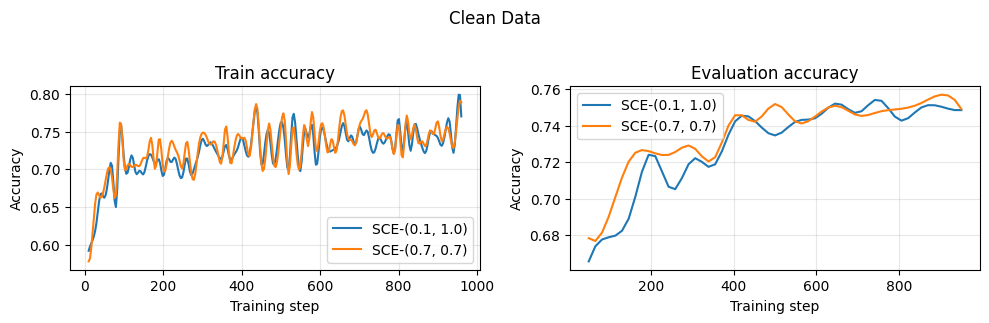

In [168]:
plot_selected(
    base_path="models_final/",
    paths=final_groups_by_loss_and_noise["sce"]["clean"],
    legend_labels=final_groups_by_loss_and_noise_legend_labels["sce"]["clean"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="Clean Data",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.570312,0.01032,7.442329,0.000010,0.5293,0.158503,5.904214,3.173551,-1.080381,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,7.998268,0.000010,0.5434,0.295973,7.051212,2.803451,-2.719099,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.625000,0.03096,6.547256,0.000010,0.4776,0.645610,6.329265,1.400977,-3.315802,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.618750,0.04128,5.947553,0.000010,0.4934,0.520184,6.897339,2.288440,-2.039699,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.584375,0.05160,4.356923,0.000009,0.5147,0.430439,6.357493,1.711673,-2.527280,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


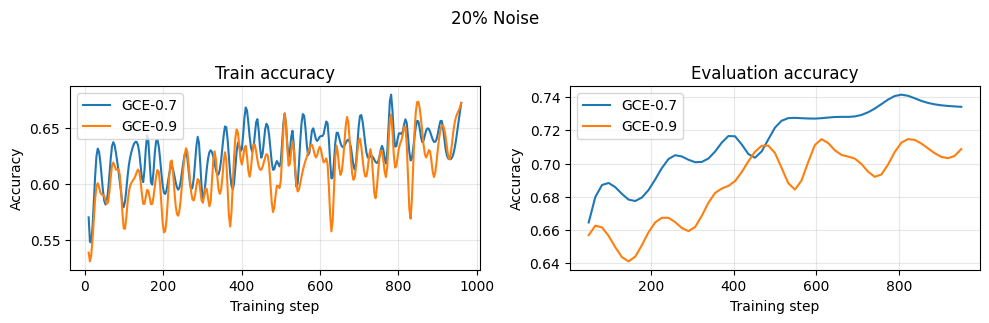

In [174]:
plot_selected(
    base_path="models_final/",
    paths=final_groups_by_loss_and_noise["gce"]["noisy20"],
    legend_labels=final_groups_by_loss_and_noise_legend_labels["gce"]["noisy20"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="20% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.567187,0.01032,6.046137,0.000010,0.7324,0.034398,-1.528845,-4.103421,-5.687634,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,3.997468,0.000010,0.6921,0.147453,-1.056627,-2.786627,-4.775573,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.593750,0.03096,3.373561,0.000010,0.6711,0.077883,-0.377421,-1.226827,-2.198720,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.578125,0.04128,3.109027,0.000010,0.6824,0.150327,0.888392,-0.625503,-2.152691,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.589063,0.05160,3.335930,0.000009,0.6662,0.130977,1.988289,0.249928,-1.035264,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


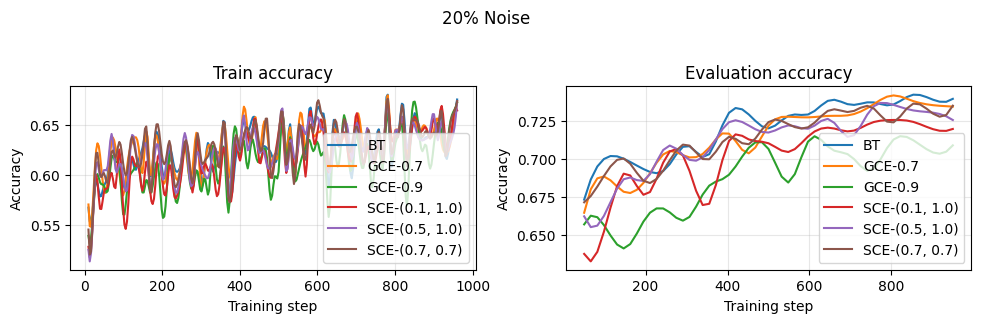

In [170]:
plot_selected(
    base_path="models_final/",
    paths=final_groups["noisy20"],
    legend_labels=final_group_legend_labels["noisy20"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="20% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.579688,0.01032,10.173501,0.000010,0.6767,0.165539,0.608692,-1.209227,-3.214442,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.643750,0.02064,5.643358,0.000010,0.6374,0.372801,2.515709,-0.178398,-2.706198,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.659375,0.03096,7.423118,0.000010,0.6101,0.352643,2.669056,0.569158,-1.299866,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.690625,0.04128,5.862025,0.000010,0.5836,0.666360,4.880084,1.516844,-1.448570,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.670312,0.05160,5.556743,0.000009,0.5877,0.471907,4.830764,2.196658,-0.600705,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


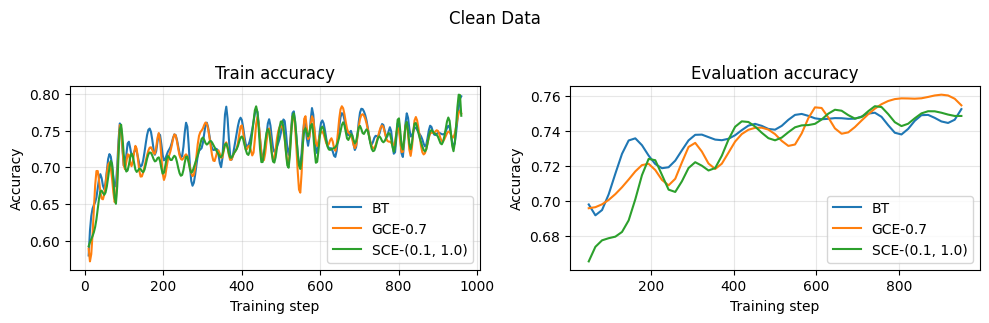

In [161]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["clean"],
    legend_labels=best_groups_legend_labels["clean"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="Clean Data",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.567187,0.01032,6.046137,0.000010,0.7324,0.034398,-1.528845,-4.103421,-5.687634,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.562500,0.02064,3.997468,0.000010,0.6921,0.147453,-1.056627,-2.786627,-4.775573,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.593750,0.03096,3.373561,0.000010,0.6711,0.077883,-0.377421,-1.226827,-2.198720,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.578125,0.04128,3.109027,0.000010,0.6824,0.150327,0.888392,-0.625503,-2.152691,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.589063,0.05160,3.335930,0.000009,0.6662,0.130977,1.988289,0.249928,-1.035264,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


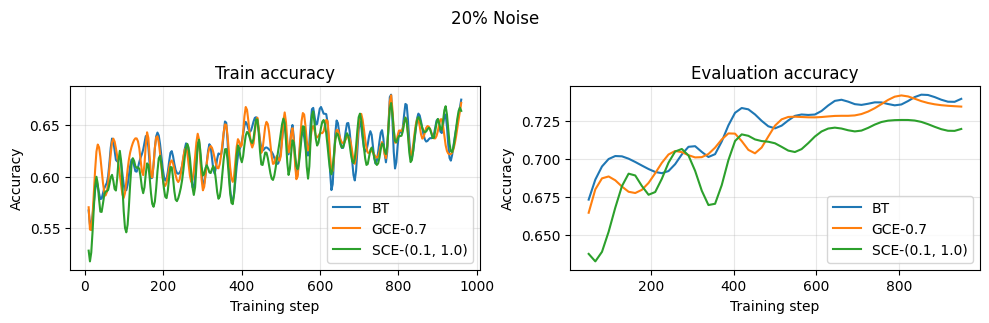

In [162]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["noisy20"],
    legend_labels=best_groups_legend_labels["noisy20"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="20% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)

,accuracy,epoch,grad_norm,learning_rate,loss,margin,max_reward,mean_reward,min_reward,num_tokens,...,eval_accuracy,eval_loss,eval_margin,eval_max_reward,eval_mean_reward,eval_min_reward,eval_num_tokens,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.492188,0.01032,5.213758,0.000010,0.7259,0.002485,5.326846,3.565464,1.687398,579549.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.521875,0.02064,2.177735,0.000010,0.7064,-0.007228,4.235545,3.233110,2.101016,1124618.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.496875,0.03096,2.361068,0.000010,0.6935,0.010059,2.813201,1.854601,0.995472,1676721.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.492188,0.04128,1.410109,0.000010,0.6979,-0.002217,2.747095,1.861573,1.238248,2215126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.520312,0.05160,1.405182,0.000009,0.6909,0.009434,1.626536,1.132094,0.530329,2761136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


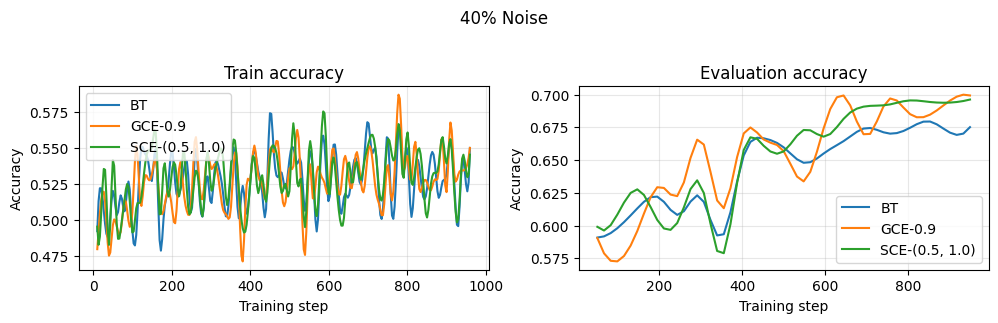

In [163]:
plot_selected(
    base_path="models_final/",
    paths=best_groups["noisy40"],
    legend_labels=best_groups_legend_labels["noisy40"],
    smoothing=1.1,
    fields_to_plot=["accuracy", "eval_accuracy"],
    title="40% Noise",
    x_title="Training step",
    y_title="Accuracy",
    subplot_titles=["Train accuracy", "Evaluation accuracy"],
)